### pip

In [41]:
# !pip install pymorphy2 gensim datasets tensorflow

### imports

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pymorphy2
from pymystem3 import Mystem

import spacy

from datasets import load_dataset #Hugging Face

from nltk.probability import FreqDist
from wordcloud import WordCloud

#6 Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
#7 TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
#Обучение моделей
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#обучение НС
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
#Word2Vec
import tensorflow as tf
from gensim.models import Word2Vec
#Hugging Face
from transformers import get_scheduler, AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, Trainer, TrainingArguments

from sklearn.metrics import confusion_matrix


# Гайд по предобработке

## 1)Lower/убираем пунктуацию-числа/ делим на слова

**simple_preprocess()** - to lowercase, убирает пунктуацию/числа и делит на слова

>Параметр **deacc** по умолчанию =  False. Если  True,то
    ё --> е    й --> и
он удаляет знаки акцентов с символов.

>Параметр **min_len** по умолчанию = 2. Mинимальную длину токенов, которые должны быть включены.

>Параметр **max_len**  по умолчанию установлен = 15. Mаксимальный размер токенов, которые должны быть включены.

In [ ]:
text = "Я точно приду с ней/her завтра/tommorow в 12:00!!!...принесу ёлку я "
tokens = simple_preprocess(text, deacc=False)#or nltk.word_tokenize
print(tokens)

['точно', 'приду', 'ней', 'her', 'завтра', 'tommorow', 'принесу', 'ёлку']


## 2) Стоп слова

In [ ]:
# stop_words = set(stopwords.words('english'))
stop_words = set(stopwords.words('russian'))
tokens = [word for word in tokens if word not in stop_words]
print(tokens)

['точно', 'приду', 'her', 'завтра', 'tommorow', 'принесу', 'ёлку']


## 3) Лемматизация - нач форма

    русский

In [ ]:
morph = pymorphy2.MorphAnalyzer()
res_lem = [morph.parse(token)[0].normal_form for token in tokens]
res_lem

['точно', 'прийти', 'her', 'завтра', 'tommorow', 'принести', 'ёлка']

In [ ]:
mystem = Mystem()
text = "Они бегают быстро. .."
lemmas = mystem.lemmatize(text)
lemmas[::2]
#работает быстрее :1мин 47 сек - pymorphy2      37 сек - Mystem
#не делать когда есть пунктуация

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


['они', 'бегать', 'быстро', ' ', '\n']

    английский

In [ ]:
nlp = spacy.load('en_core_web_sm')
text_eng = "They are running quickly fools her"
doc = nlp(text_eng)
lemmas = [token.lemma_ for token in doc]
print(lemmas)

['they', 'be', 'run', 'quickly', 'fool', 'she']


# Загрузка/очищение датасета

In [43]:
#dataset = load_dataset('ai-forever/ru-reviews-classification',  split='train', trust_remote_code = False)#trust_remote_code = True - проще но может быть опасным
dataset = load_dataset('fancyzhx/ag_news', split='train', trust_remote_code = False)
dataset = dataset.shuffle(seed=42).select(range(10000))

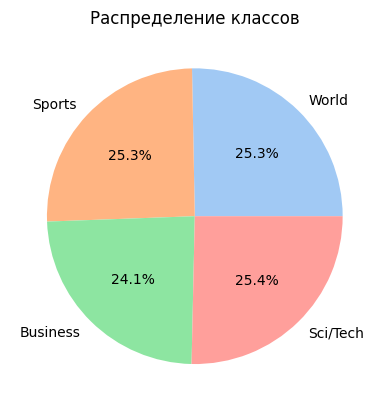

In [5]:
unique, counts = np.unique(dataset['label'], return_counts=True)
percentages = (counts / counts.sum()) * 100

colors = sns.color_palette('pastel')
labels = ['World', 'Sports', 'Business', 'Sci/Tech']
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=0, colors = colors)
plt.title('Распределение классов')
plt.show()

    0 - World
    1 - Sports
    2 - Business
    3 - Sci/Tech



## Предобработка

In [6]:
# def preprocess(texts, lang = 'ru'):
#     texts = list(map(lambda text : simple_preprocess(text, deacc=False), texts))

#     stop_words = set(stopwords.words('russian')) | {'это'}
#     texts = [[word  for word in text if word not in stop_words] for text in texts]

#     mystem = Mystem()
#     texts = [mystem.lemmatize(' '.join(text))[::2] for text in texts]

#     return texts

In [7]:
def preprocess(texts, lang = 'eng'):
    texts = list(map(lambda text : simple_preprocess(text, deacc=False), texts))

    stop_words = set(stopwords.words('english'))
    texts = [[word  for word in text if word not in stop_words] for text in texts]

    # spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
    texts = [[token.lemma_ for token in nlp(' '.join(text))] for text in tqdm(texts) ]

    return texts

In [8]:
texts = preprocess(dataset['text'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
y = np.array(dataset['label'])
yt = torch.from_numpy(y).to(torch.int64)

## Частотный анализ

In [10]:
combined_texts = [word for text in texts for word in text]
fdist = FreqDist(combined_texts)
n_all = fdist.N()

In [11]:
threshold = 1e-4 #т.е слово не выброс если встречается хотя бы раз в 10 000 слов
threshold_in_words = round(n_all * threshold)
freq = {k : v for k, v in fdist.items() if v >= threshold_in_words}
threshold_in_words

26

In [12]:
# не всегда 8 !!!!!!
limit_in_words = fdist.most_common(10)[-1][1]
freq = {k : v for k, v in freq.items() if v < limit_in_words}

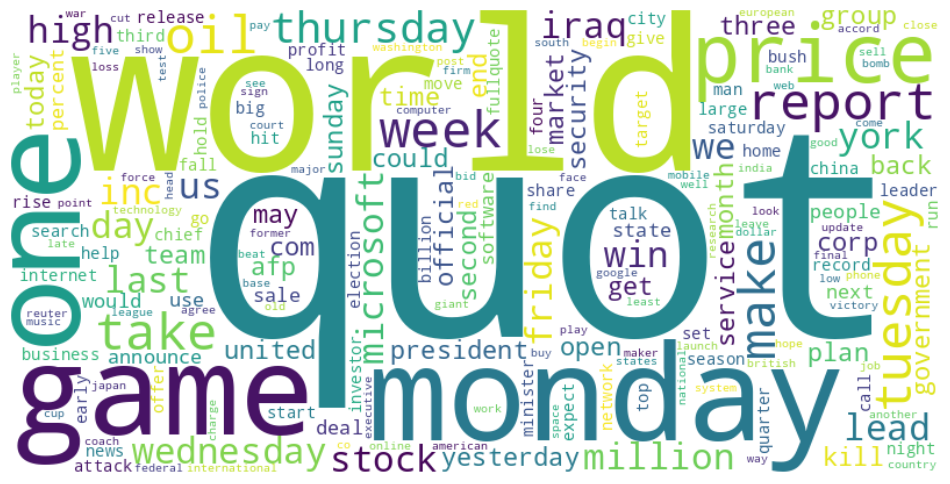

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

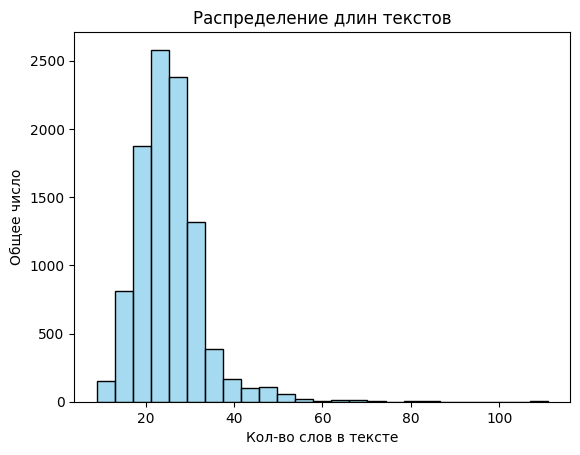

In [15]:
lens = list(map(len, texts))
sns.histplot(lens, kde=False, bins=25, color='skyblue')
plt.xlabel('Кол-во слов в тексте')
plt.ylabel('Общее число')
plt.title('Распределение длин текстов');

In [16]:
dataset[:5]

{'text': ['Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.',
  'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.',
  'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.',
  'U2 pitches for Apple New iTunes ads airing during baseball games Tuesday will feature the advertising-shy Irish rockers.',
  'S African TV in beheading blunder Public broadcaster SABC apologises after news bulletin shows footage of American beheaded in Iraq.'],
 'label': [0, 1, 0, 3, 0]}

In [17]:
n_count_words = sum(freq.values())
n_unique = len(freq)
texts_no_list = [' '.join(text) for text in texts]
n_count_words, n_unique

(174850, 1817)

#Bag of words

In [18]:
vectorizer = CountVectorizer(vocabulary=freq.keys())
X_bow = vectorizer.fit_transform(texts_no_list).toarray()
X_bow.shape

(10000, 1817)

#TF - IDF

In [19]:
vectorizer = TfidfVectorizer(vocabulary=freq.keys())
X_tf = vectorizer.fit_transform(texts_no_list).toarray()
X_tf.shape

(10000, 1817)

#Обучение моделей

In [20]:
train, test = train_test_split(np.arange(len(y)), test_size=0.90, random_state = 0)

## 1)Наивный Байесовский классификатор

In [ ]:
model = MultinomialNB()
model.fit(X_bow[train], y[train])
print(f'Accuracy : {accuracy_score(y[test], model.predict(X_bow[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_bow[train])) :.3f}')

Accuracy : 0.831
Train Accuracy : 0.954


In [ ]:
model = MultinomialNB()
model.fit(X_tf[train], y[train])
print(f'Accuracy : {accuracy_score(y[test], model.predict(X_tf[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_tf[train])) :.3f}')

Accuracy : 0.833
Train Accuracy : 0.952


## 2)Метод опорных векторов (SVM)

In [ ]:
model = SVC()
model.fit(X_bow[train], y[train])
print(f'Accuracy : {accuracy_score(y[test], model.predict(X_bow[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_bow[train])) :.3f}')

Accuracy : 0.790
Train Accuracy : 0.983


In [ ]:
model = SVC()
model.fit(X_tf[train], y[train])
print(f'Accuracy : {accuracy_score(y[test], model.predict(X_tf[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_tf[train])) :.3f}')

Accuracy : 0.826
Train Accuracy : 0.996


## 3)Метод k ближайших соседей (k-NN)

In [ ]:
model = KNeighborsClassifier()
model.fit(X_bow[train], y[train])
print(f'Accuracy (k-NN, BoW): {accuracy_score(y[test], model.predict(X_bow[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_bow[train])) :.3f}')

Accuracy (k-NN, BoW): 0.478
Train Accuracy : 0.721


In [ ]:
model = KNeighborsClassifier()
model.fit(X_tf[train], y[train])
print(f'Accuracy (k-NN, TF-IDF): {accuracy_score(y[test], model.predict(X_tf[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_tf[train])) :.3f}')

Accuracy (k-NN, TF-IDF): 0.757
Train Accuracy : 0.861


## 4)Случайный лес

In [ ]:
model = RandomForestClassifier()
model.fit(X_bow[train], y[train])
print(f'Accuracy: {accuracy_score(y[test], model.predict(X_bow[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_bow[train])) :.3f}')

Accuracy: 0.746
Train Accuracy : 1.000


In [ ]:
model = RandomForestClassifier()
model.fit(X_tf[train], y[train])
print(f'Accuracy: {accuracy_score(y[test], model.predict(X_tf[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_tf[train])) :.3f}')

Accuracy: 0.745
Train Accuracy : 1.000


## 5) Градиентный бустинг

In [ ]:
model = GradientBoostingClassifier()
model.fit(X_bow[train], y[train])
print(f'Accuracy (Gradient Boosting, BoW): {accuracy_score(y[test], model.predict(X_bow[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_bow[train])) :.3f}')

Accuracy (Gradient Boosting, BoW): 0.752
Train Accuracy : 0.970


In [ ]:
model = GradientBoostingClassifier()
model.fit(X_tf[train], y[train])
print(f'Accuracy (Gradient Boosting, TF-IDF): {accuracy_score(y[test], model.predict(X_tf[test])) :.3f}')
print(f'Train Accuracy : {accuracy_score(y[train], model.predict(X_tf[train])) :.3f}')

Accuracy (Gradient Boosting, TF-IDF): 0.739
Train Accuracy : 0.988


In [ ]:
names = [
    "Наивный Байесовский классификатор",
    "Метод опорных векторов (SVM)",
    "Метод k ближайших соседей (k-NN)",
    "Случайный лес",
    "Градиентный бустинг"]

bow_test = [0.831, 0.790, 0.478, 0.746, 0.752]
bow_train = [0.954, 0.983, 0.721, 1.000, 0.970]
tf_test = [0.833, 0.826, 0.757, 0.745, 0.739]
tf_train = [0.952, 0.996, 0.861, 1.000, 0.988]

df = pd.DataFrame({'BOW-TEST': bow_test,
                   'BOW-TRAIN': bow_train,
                   'TF-IDF-TEST': tf_test,
                   'TF-IDF-TRAIN': tf_train}, index = names)
df

,BOW-TEST,BOW-TRAIN,TF-IDF-TEST,TF-IDF-TRAIN
Наивный Байесовский классификатор,0.831,0.954,0.833,0.952
Метод опорных векторов (SVM),0.790,0.983,0.826,0.996
Метод k ближайших соседей (k-NN),0.478,0.721,0.757,0.861
Случайный лес,0.746,1.000,0.745,1.000
Градиентный бустинг,0.752,0.970,0.739,0.988


## 6) НС

In [21]:
# from_numpy менее затратен !!!
X_bowt = torch.from_numpy(X_bow).to(torch.float32)
X_tft = torch.from_numpy(X_tf).to(torch.float32)
yt = torch.from_numpy(y).to(torch.int64)

In [22]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [31]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    def fit(self, X, y, X_test, y_test, n_epoch = 10, batch_size = 1024):
        best_acc = 0
        dataset = TextDataset(X, y)
        loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay = 2e-2)

        self.train()
        for epoch in tqdm(range(n_epoch+1), desc="Training Epochs"):
            for batch in loader:
                X_batch, y_batch = batch
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()



            test_acc = self.validate(X_test, y_test, shown = False)
            if test_acc > best_acc:
                  self.best_params = self.state_dict()

            if epoch%10 == 0:
                self.eval()
                print(f'|Epoch : {epoch : ^3}', end = ' | ')
                self.validate(X, y, title = 'Train')
                self.validate(X_test, y_test)
                print('')


    def validate(self, X, y, batch_size = 512, title = 'Test', shown = True):
        dataset = TextDataset(X, y)
        loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
        criterion = nn.CrossEntropyLoss()


        self.eval()
        accuracy = 0
        loss = 0
        with torch.no_grad():
            for batch in loader:
                X_batch, y_batch = batch
                pred = self(X_batch)
                accuracy += sum(pred.argmax(1) == y_batch)
                loss += criterion(pred, y_batch)

        if shown : print(f'{title} Accuracy: {accuracy/len(y):.4f} | {title} Loss: {loss/len(loader):.4f}', end = ' | ')
        return (accuracy/len(y)).item()

In [32]:
input_dim = X_bowt.shape[1]
hidden_dim = 712
output_dim = 4

In [34]:
model1 = TextClassifier(input_dim, hidden_dim, output_dim)
model1.fit(X_tft[train], yt[train], X_tft[test], yt[test], n_epoch = 150)

Training Epochs:   0%|          | 0/151 [00:00<?, ?it/s]

|Epoch :  0  | Train Accuracy: 0.2530 | Train Loss: 1.3836 | Test Accuracy: 0.2530 | Test Loss: 1.3842 | 
|Epoch : 10  | Train Accuracy: 0.7410 | Train Loss: 1.3684 | Test Accuracy: 0.6724 | Test Loss: 1.3728 | 
|Epoch : 20  | Train Accuracy: 0.7970 | Train Loss: 1.3503 | Test Accuracy: 0.7158 | Test Loss: 1.3592 | 
|Epoch : 30  | Train Accuracy: 0.8530 | Train Loss: 1.3105 | Test Accuracy: 0.7560 | Test Loss: 1.3291 | 
|Epoch : 40  | Train Accuracy: 0.8900 | Train Loss: 1.2431 | Test Accuracy: 0.7841 | Test Loss: 1.2780 | 
|Epoch : 50  | Train Accuracy: 0.8970 | Train Loss: 1.1556 | Test Accuracy: 0.7981 | Test Loss: 1.2118 | 
|Epoch : 60  | Train Accuracy: 0.9080 | Train Loss: 1.0634 | Test Accuracy: 0.8066 | Test Loss: 1.1420 | 
|Epoch : 70  | Train Accuracy: 0.9220 | Train Loss: 0.9811 | Test Accuracy: 0.8117 | Test Loss: 1.0809 | 
|Epoch : 80  | Train Accuracy: 0.9290 | Train Loss: 0.9168 | Test Accuracy: 0.8163 | Test Loss: 1.0341 | 
|Epoch : 90  | Train Accuracy: 0.9400 | Train 

In [35]:
model1_best = TextClassifier(input_dim, hidden_dim, output_dim)
model1_best.load_state_dict(model1.best_params)

<All keys matched successfully>

In [36]:
model1_best.validate(X_tft[test], yt[test])

Test Accuracy: 0.8214 | Test Loss: 0.9754 | 

0.8214444518089294

# RNN & Word2Vec

In [44]:
#dataset = load_dataset('ai-forever/ru-reviews-classification',  split='train', trust_remote_code = False)#trust_remote_code = True - проще но может быть опасным
dataset2 = load_dataset('fancyzhx/ag_news', split='train', trust_remote_code = False)
dataset2 = dataset2.shuffle(seed=42).select(range(50000))

In [ ]:
def preprocess2(texts, lang = 'eng'):
    texts = list(map(lambda text : simple_preprocess(text, deacc=False), texts))
    stop_words = set(stopwords.words('english'))
    texts = [[word  for word in text if word not in stop_words] for text in texts]
    return texts

In [ ]:
texts = preprocess2(dataset2['text'])

In [ ]:
y = np.array(dataset2['label'])
yt = torch.from_numpy(y).to(torch.int64)

In [ ]:
class Vocab:
  def __init__(self, texts):
      self.sp_tokens = {0 : 'PAD', 1 : 'EOS', 2 : 'UNK'}
      self.unique_words = set([word.lower() for text in texts for word in text ])
      self.int2word = self.sp_tokens | dict(enumerate(self.unique_words, 3))
      self.word2int = {val:key for key, val in self.int2word.items()}


  def texts_to_int(self, texts, max_len = 25):
      res = []
      for text in texts:
          n = max_len if len(text) > max_len else len(text)
          seq = [self.word2int.get(word, 2) for word in text[:n]]
          if n < max_len:
              eos = [1]
              pad = [0] * (max_len - n - 1)
              seq = seq + eos + pad
          res.append(seq)

      return res

In [ ]:
v = Vocab(texts)
vect_text = np.array(v.texts_to_int(texts))

In [ ]:
model = Word2Vec(sentences = texts, vector_size = 256, window = 5, min_count=0, workers=4)

In [ ]:
emb_size = 256
emb_matrix = np.array([model.wv[token] for token in list(v.word2int.keys())[3:]])
emb_matrix = np.concatenate([np.zeros((2, emb_size)), np.mean(emb_matrix, 0)[None, :], emb_matrix])

In [ ]:
emb_texts = (torch.tensor(emb_matrix)[vect_text]).to(torch.float32)
emb_texts.shape

torch.Size([50000, 25, 256])

In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
dataset_train, dataset_test, dataset_val = random_split(TextDataset(emb_texts, yt), [0.7, 0.2, 0.1])
#Делить обязательно так!!! Если индексированием - будут ошибки

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class RNNTextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNTextClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p = 0.3)


    def forward(self, x):
        out, hid = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.tanh(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

    def fit(self, dataset_train, dataset_val, n_epoch = 10, batch_size = 512):
        best_acc = 0
        loader = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay = 1e-4)

        for epoch in tqdm(range(1, n_epoch+1), desc="Training Epochs"):
            self.train()
            for X_batch, y_batch in tqdm(loader, desc="Bathes", leave = False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()


            #Оценка
            self.eval()
            if epoch%1 == 0:
                loss_train, acc_train = self.validate(dataset_train)
                loss_test, acc_test = self.validate(dataset_val)
                if acc_test > best_acc:
                    self.best_params = self.state_dict()
                print(f'|Epoch : {epoch : ^3}| Train Loss : {loss_train :.3f}| Train Acc : {acc_train :.3f}', end = ' ')
                print(f'|Val Loss : {loss_test :.3f}| Val Acc : {acc_test :.3f}')
            else:
              if self.validate(dataset_val)[1] > best_acc:
                    self.best_params = self.state_dict()

    @torch.no_grad()
    def validate(self, dataset, batch_size = 1024, title = 'Test', shown = True):
        loader = DataLoader(dataset, batch_size = batch_size, shuffle = False)
        criterion = nn.CrossEntropyLoss()
        accuracy, loss = 0, 0

        self.eval()
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = self(X_batch)
            accuracy += sum(pred.argmax(1) == y_batch)
            loss += criterion(pred, y_batch)

        return (loss / len(loader)).item(), (accuracy / len(dataset)).item()

In [ ]:
# Параметры модели
input_size = 256  # Размер векторов эмбеддингов
hidden_size = 256  # Размер скрытого состояния
num_layers = 2  # Количество слоев RNN
num_classes = 4  # Количество классов

# Создание модели
rnn_classifier = RNNTextClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
rnn_classifier.fit(dataset_train, dataset_val, n_epoch = 10)

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  1 | Train Loss : 0.387| Train Acc : 0.870 |Val Loss : 0.379| Val Acc : 0.870


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  2 | Train Loss : 0.351| Train Acc : 0.880 |Val Loss : 0.345| Val Acc : 0.881


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  3 | Train Loss : 0.328| Train Acc : 0.886 |Val Loss : 0.327| Val Acc : 0.888


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  4 | Train Loss : 0.321| Train Acc : 0.888 |Val Loss : 0.321| Val Acc : 0.887


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  5 | Train Loss : 0.332| Train Acc : 0.881 |Val Loss : 0.345| Val Acc : 0.872


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  6 | Train Loss : 0.296| Train Acc : 0.897 |Val Loss : 0.309| Val Acc : 0.891


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  7 | Train Loss : 0.291| Train Acc : 0.899 |Val Loss : 0.305| Val Acc : 0.890


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  8 | Train Loss : 0.286| Train Acc : 0.898 |Val Loss : 0.316| Val Acc : 0.892


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch :  9 | Train Loss : 0.274| Train Acc : 0.903 |Val Loss : 0.305| Val Acc : 0.894


Bathes:   0%|          | 0/69 [00:00<?, ?it/s]

|Epoch : 10 | Train Loss : 0.256| Train Acc : 0.910 |Val Loss : 0.294| Val Acc : 0.894


In [ ]:
loss_test, acc_test = rnn_classifier.validate(dataset_test)
print(f'|Val Loss : {loss_test :.3f}| Val Acc : {acc_test :.3f}')


|Val Loss : 0.306| Val Acc : 0.895


# Transformers

## Загрузка датасета

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [45]:
dataset_name = 'fancyzhx/ag_news'
ds = load_dataset(dataset_name, trust_remote_code = False)#trust_remote_code = True - проще но может быть опасным
ds

## BERT

In [ ]:
model_name = 'JungleLee/bert-toxic-comment-classification'
model_name = 'google-bert/bert-base-uncased'

# tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return lambda x : tokenizer(x["text"],
                                padding="max_length",
                                truncation=True,
                                max_length=80,
                                )

In [ ]:
def prepare(dataset, model_name, n = False):
    if not n: n = dataset.num_rows
    res = dataset.shuffle(seed=42).select(range(n))
    tok_function = tokenize_function(model_name)
    res = res.map(tok_function, batched=True, num_proc = 8)
    res = res.remove_columns(["text"]).rename_column("label", "labels")
    res.set_format("torch")
    return res

In [46]:
train_dataset = prepare(ds['train'], model_name,  n = 20000)
test_dataset = prepare(ds['test'], model_name, n = 2000)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Fine_Tuning

In [47]:
# Загрузка предобученной модели BERT для классификации
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels = 4,
                                                      ignore_mismatched_sizes = True).to(device)

In [ ]:
# for name, param in model.named_parameters():
#     if 'classifier' not in name:
#         param.requires_grad = False

In [ ]:
num_epochs = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear",                 # Тип scheduler
    optimizer=optimizer,           # Оптимизатор, на который будет влиять scheduler
    num_warmup_steps=0,            # Число шагов warmup
    num_training_steps=num_training_steps  # Общее количество шагов обучения
)

In [ ]:
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(train_dataloader, desc = 'Batches'):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

  0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

### Оценка модели

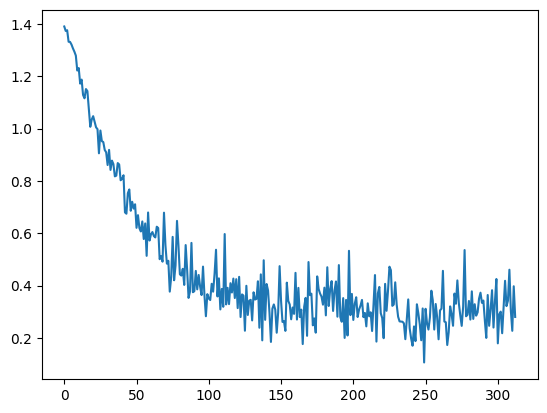

In [ ]:
plt.plot(losses)

In [ ]:
def predict(loader, model = model):
    preds = torch.tensor([])
    model.eval()
    for batch in tqdm(loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits.to('cpu')
        preds = torch.cat([preds, torch.argmax(logits, dim=-1)])
    return preds

In [ ]:
pred_test = predict(test_dataloader)
label_test = test_dataset['labels']

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# pred_train = predict(DataLoader(train_dataset, shuffle=False, batch_size=128))
# label_train = train_dataset['labels']

In [ ]:
def accuracy(pred, true, add = 'TEST'):
    acc = ((pred == true).sum() / len(true))
    plt.figure(figsize = (8, 6))
    plt.title(f'{add} ACCURACY = {acc : .2%}', fontsize = 20)
    sns.heatmap(confusion_matrix(pred, true), fmt = '.3g', annot = True);

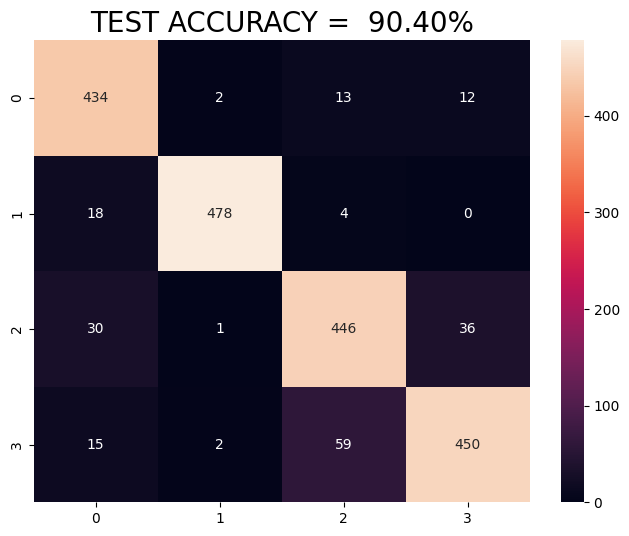

In [ ]:
accuracy(pred_test, label_test)

##Сохранение / Загрузка модели

In [ ]:
path = '/content/drive/MyDrive/Курсовые/Transformers 1'
torch.save(model.state_dict(), path + '/BERT.pth')

In [48]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels = 4,
                                                      ignore_mismatched_sizes = True).to(device)
bert.load_state_dict(torch.load('BERT.pth'))

## RoBERTa

In [ ]:
model_name = 'FacebookAI/roberta-base'

train_dataset = prepare(ds['train'], model_name,  n = 20000)
test_dataset = prepare(ds['test'], model_name, n = 2000)

batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Fine_Tuning

In [ ]:
# Загрузка предобученной модели RoBERTa для классификации
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels = 4,
                                                      ignore_mismatched_sizes = True).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
num_training_steps = num_epochs * len(train_dataloader)/4

lr_scheduler = get_scheduler(
    name="linear",                 # Тип scheduler
    optimizer=optimizer,           # Оптимизатор, на который будет влиять scheduler
    num_warmup_steps=0,            # Число шагов warmup
    num_training_steps=num_training_steps  # Общее количество шагов обучения
)

In [37]:
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(train_dataloader, desc = 'Batches'):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

In [38]:
# plt.plot(losses);

In [ ]:
pred_test = predict(test_dataloader, model = model)
label_test = test_dataset['labels']

  0%|          | 0/32 [00:00<?, ?it/s]

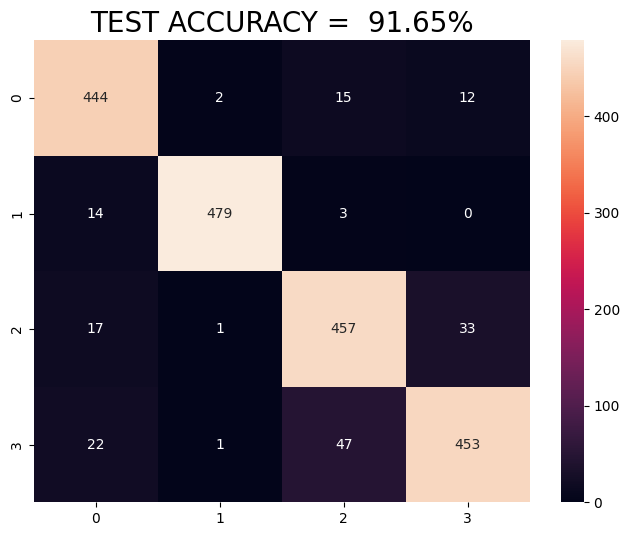

In [ ]:
accuracy(pred_test, label_test)

In [ ]:
path = '/content/drive/MyDrive/Курсовые/Transformers 1'
path = '/content/drive/MyDrive'

torch.save(model.state_dict(), path + '/RoBERTa.pth')

In [49]:
roberta = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels = 4,
                                                      ignore_mismatched_sizes = True).to(device)
roberta.load_state_dict(torch.load('RoBERTa.pth'))

## electra

In [ ]:
model_name = 'google/electra-base-discriminator'

train_dataset = prepare(ds['train'], model_name,  n = 20000)
test_dataset = prepare(ds['test'], model_name, n = 2000)

batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Fine_Tuning

In [ ]:
# Загрузка предобученной модели RoBERTa для классификации
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels = 4,
                                                      ignore_mismatched_sizes = True).to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear",                 # Тип scheduler
    optimizer=optimizer,           # Оптимизатор, на который будет влиять scheduler
    num_warmup_steps=0,            # Число шагов warmup
    num_training_steps=num_training_steps  # Общее количество шагов обучения
)

In [ ]:
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(train_dataloader, desc = 'Batches'):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

  0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# for name, param in model.named_parameters():
#     if 'classifier' not in name:
#         param.requires_grad = False

In [ ]:
num_epochs = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear",                 # Тип scheduler
    optimizer=optimizer,           # Оптимизатор, на который будет влиять scheduler
    num_warmup_steps=0,            # Число шагов warmup
    num_training_steps=num_training_steps  # Общее количество шагов обучения
)

In [ ]:
losses = []

In [ ]:

model.train()
for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(train_dataloader, desc = 'Batches'):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

  0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

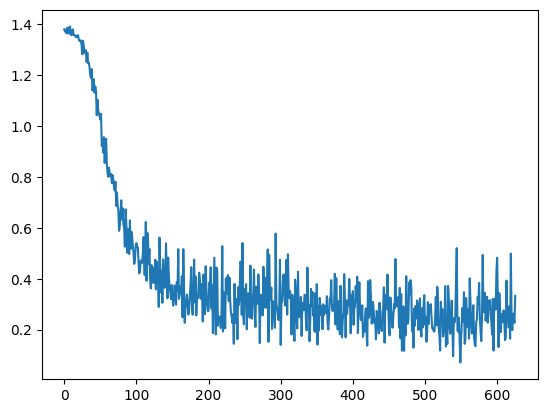

In [ ]:
plt.plot(losses);

In [ ]:
pred_test = predict(test_dataloader, model = model)
label_test = test_dataset['labels']

  0%|          | 0/32 [00:00<?, ?it/s]

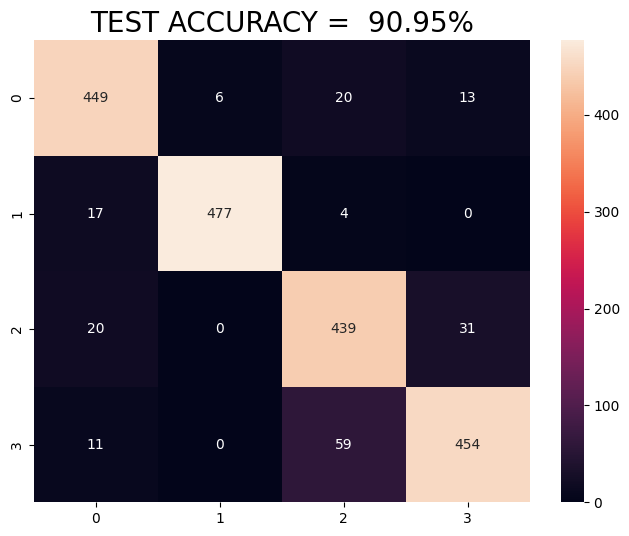

In [ ]:
accuracy(pred_test, label_test)

In [ ]:
path = '/content/drive/MyDrive/Курсовые/Transformers 1'
path = '/content/drive/MyDrive'

torch.save(model.state_dict(), path + '/ELECTRA.pth')

## DeBERTa

In [ ]:
model_name = 'microsoft/deberta-base'

train_dataset = prepare(ds['train'], model_name,  n = 20000)
test_dataset = prepare(ds['test'], model_name, n = 2000)

batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map (num_proc=8):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2000 [00:00<?, ? examples/s]

### Fine_Tuning

In [ ]:
# Загрузка предобученной модели RoBERTa для классификации
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                      num_labels = 4,
                                                      ignore_mismatched_sizes = True).to(device)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
num_training_steps = num_epochs * len(train_dataloader)/5

lr_scheduler = get_scheduler(
    name="linear",                 # Тип scheduler
    optimizer=optimizer,           # Оптимизатор, на который будет влиять scheduler
    num_warmup_steps=0,            # Число шагов warmup
    num_training_steps=num_training_steps  # Общее количество шагов обучения
)

In [39]:
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for batch in tqdm(train_dataloader, desc = 'Batches'):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

In [40]:
# plt.plot(losses);

In [ ]:
pred_test = predict(test_dataloader, model = model)
label_test = test_dataset['labels']

  0%|          | 0/32 [00:00<?, ?it/s]

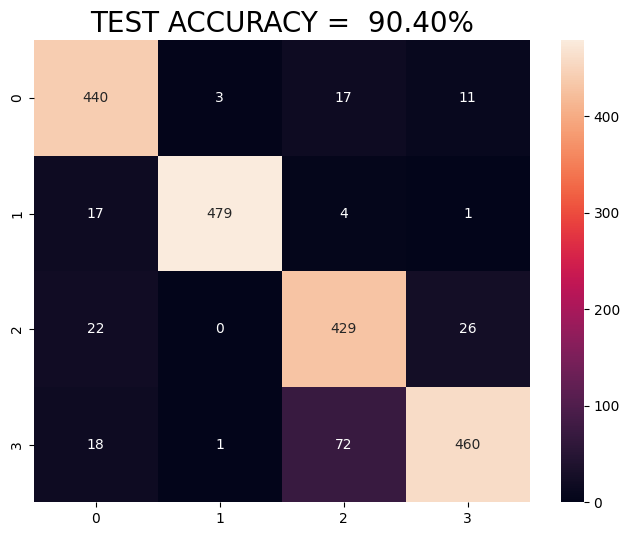

In [ ]:
accuracy(pred_test, label_test)

In [ ]:
path = '/content/drive/MyDrive/Курсовые/Transformers 1'
path = '/content/drive/MyDrive'

torch.save(model.state_dict(), path + '/DeBERTa.pth')